In [38]:
#MISE EN PLACE DES BIBLIOTHEQUES
# ===============================================
# IMPORTS STANDARD ET DE BASE
# ===============================================
import pandas as pd
import numpy as np
import time
import os
import re
import itertools

# ===============================================
# IMPORTS VISUALISATION ET API EXTERNE
# ===============================================
import matplotlib.pyplot as plt
import seaborn as sns
from stackapi import StackAPI 
from datetime import datetime, timedelta

# ===============================================
# IMPORTS MLOPS ET TRACKING
# ===============================================
import mlflow
from mlflow.exceptions import MlflowException
# from mlflow.tracking import MlflowClient # Peut être ajouté si nécessaire pour la fin du projet

# ===============================================
# IMPORTS NLP ET PRÉTRAITEMENT
# ===============================================
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 
# Téléchargements NLTK (à laisser en début de notebook)
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt_tab')

# ===============================================
# IMPORTS SCIKIT-LEARN
# ===============================================
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer # <-- AJOUT CRUCIAL MANQUANT !
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss

# ===============================================
# IMPORTS EMBEDDINGS (GENSIM, HUGGING FACE, TF-HUB)
# ===============================================
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModel
import torch
import tensorflow as tf
import tensorflow_hub as hub


In [20]:

# Configuration MLFlow - définir le chemin de tracking
mlflow.set_tracking_uri("file:///C:/Users/lza/Documents/P05_Projet_tags_StackOverflow/mlruns")
print(f" MLFlow Tracking URI configuré : {mlflow.get_tracking_uri()}")

 MLFlow Tracking URI configuré : file:///C:/Users/lza/Documents/P05_Projet_tags_StackOverflow/mlruns


# test  qualité API

In [21]:
# --- Critères de la Requête ---
TAG = 'python'
MIN_SCORE = 8
PAGE_SIZE = 50 # Le maximum par requête non authentifiée

# Période définie : Nous prenons les 3 derniers mois comme exemple de "période définie"
to_date = int(time.time()) # Aujourd'hui (timestamp UNIX)
from_date = int((datetime.now() - timedelta(days=365)).timestamp()) # Il y a 90 jours

# 1. Initialiser le client de l'API pour Stack Overflow
SITE = StackAPI('stackoverflow')

# 2. Effectuer la requête
print(f"Recherche de {PAGE_SIZE} questions avec le tag '{TAG}' et un score > {MIN_SCORE} sur les 90 derniers jours...")

try:
    # La méthode fetch utilise l'endpoint 'questions' par défaut
    questions_data = SITE.fetch(
        'questions', 
        pagesize=PAGE_SIZE, 
        tagged=TAG, 
        sort='votes',   # Trier par votes pour appliquer le filtre 'min'
        min=MIN_SCORE,  # Filtrer sur le score minimal (votes)
        fromdate=from_date, 
        todate=to_date,

    )

    # 3. Préparer les données pour le DataFrame
    data_list = []
    items = questions_data.get('items', [])
    
    for q in items:
                # Nous ne prenons que les données nécessaires (RGPD)
        data_list.append({
            'date_creation': datetime.fromtimestamp(q['creation_date']).strftime('%Y-%m-%d %H:%M:%S'),
            'titre': q['title'],
            'tags': ", ".join(q['tags']) if 'tags' in q else 'N/A',
            'score': q['score'],
            'body_snippet': q.get('body', 'N/A')[:100] + '...' 
        })

    # 4. Afficher le DataFrame
    df_api_test = pd.DataFrame(data_list)
    print(f"\n--- Résultat du Test API ---")
    print(f"Questions récupérées : {len(df_api_test)}/{PAGE_SIZE} (Succès de l'appel).")
    print(df_api_test.head())

except Exception as e:
    print(f"\nErreur lors de l'appel à l'API : {e}")

Recherche de 50 questions avec le tag 'python' et un score > 8 sur les 90 derniers jours...

--- Résultat du Test API ---
Questions récupérées : 56/50 (Succès de l'appel).
         date_creation                                              titre  \
0  2025-01-09 22:04:59      How to add requirements.txt to uv environment   
1  2024-12-18 12:45:52  &#39;super&#39; object has no attribute &#39;_...   
2  2025-01-13 16:24:07  How/why are {2,3,10} and {x,3,10} with x=2 ord...   
3  2025-08-02 18:59:55  How to set up a simple hello-world example whe...   
4  2025-04-02 11:41:54  import numpy failed after upgrading MacOS to 15.4   

                                              tags  score body_snippet  
0                          python, python-venv, uv     48       N/A...  
1  python, machine-learning, scikit-learn, xgboost     32       N/A...  
2                python, cpython, python-internals     21       N/A...  
3                    python, c, python-3.x, cython     20       N/A...  


# Préparation et Nettoyage des données

In [22]:
# Simulation du chargement du fichier CSV des 50 000 questions
try:
    df_train = pd.read_csv('./data/stack_overflow_brut.csv', encoding='utf-8')
    # On va créer une colonne de texte combiné pour l'analyse
    df_train['Text_Raw'] = df_train['Title'] + " " + df_train['Body']
    print("DataFrame d'entraînement chargé avec succès.")
except FileNotFoundError:
    print("Erreur : Fichier d'entraînement 50k non trouvé. Passez à la simulation.")

# --- Fonctions de Nettoyage ---

def clean_html_and_code(text):
    """
    Supprime les balises HTML et extrait le texte brut.
    Ceci est VITAL car le 'Body' Stack Overflow est en HTML.
    """
    if not isinstance(text, str):
        return ""
    # Utilise BeautifulSoup pour parser et extraire le texte
    soup = BeautifulSoup(text, 'html.parser')
    cleaned_text = soup.get_text(separator=' ')
    
    # Optionnel : Remplacer les retours à la ligne par des espaces
    cleaned_text = re.sub('\n', ' ', cleaned_text)
    return cleaned_text

# Application de la première étape de nettoyage
print("\nNettoyage du HTML en cours...")
df_train['Text_Cleaned'] = df_train['Text_Raw'].apply(clean_html_and_code)

# Affichage des 5 premières lignes pour valider le nettoyage
print("Aperçu du texte nettoyé :")
print(df_train[['Text_Raw', 'Text_Cleaned']].head(1)['Text_Cleaned'].iloc[0])

DataFrame d'entraînement chargé avec succès.

Nettoyage du HTML en cours...


C:\Users\lza\AppData\Local\Temp\ipykernel_22864\842519030.py:20: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(text, 'html.parser')


Aperçu du texte nettoyé :
Paging a collection with LINQ  How do you page through a collection in LINQ given that you have a  startIndex  and a  count ?  


# Nettoyage linguistique

In [23]:
# Tokenizer
def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words

stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Assurez-vous que votre colonne 'Text_Cleaned' est bien le texte sans HTML

# 1. Création de la colonne pour LDA / Bag-of-Words (avec lemmatisation)
# C'est la préparation la plus complète et la plus efficace pour les méthodes classiques
df_train['Tokens_LDA'] = df_train['Text_Cleaned'].apply(lambda x : transform_bow_lem_fct(x))

# 2. Création de la colonne pour le Deep Learning (sans lemmatisation ni stop words)
# Les modèles comme BERT et USE préfèrent garder le contexte intact
df_train['Tokens_DL'] = df_train['Text_Cleaned'].apply(lambda x : transform_dl_fct(x))

# Affichage pour la validation
print("--- Vérification du Pipeline de Nettoyage ---")
print(df_train[['Text_Cleaned', 'Tokens_LDA', 'Tokens_DL']].head(2))

--- Vérification du Pipeline de Nettoyage ---
                                        Text_Cleaned  \
0  Paging a collection with LINQ  How do you page...   
1  How do I add existing comments to RDoc in Ruby...   

                                          Tokens_LDA  \
0  paging collection linq how page collection lin...   
1  how add existing comment rdoc ruby want format...   

                                           Tokens_DL  
0  paging a collection with linq how do you page ...  
1  how do i add existing comments to rdoc in ruby...  


# Création du dictionnaire et du corpus

In [24]:

# Note : Votre fonction transform_bow_lem_fct retourne une CHAÎNE de caractères.
# Gensim a besoin d'une LISTE de listes de mots. Nous utilisons .apply(str.split) 
# pour convertir chaque chaîne en liste de mots.
print("Démarrage de la création du Dictionnaire et du Corpus...")

# 1. Création du Dictionnaire
# Cette ligne identifie et numérote tous les mots uniques (le vocabulaire)
dictionary = corpora.Dictionary(df_train['Tokens_LDA'].apply(str.split))

# 2. Filtrage des Extrêmes (Crucial pour le bruit)
# On garde un vocabulaire pertinent pour le modèle (mots ni trop rares, ni trop fréquents)
dictionary.filter_extremes(no_below=5, no_above=0.5) 

# 3. Création du Corpus (Format Bag-of-Words)
# Chaque document est transformé en une liste de (id_mot, fréquence)
corpus = [dictionary.doc2bow(tokens.split()) for tokens in df_train['Tokens_LDA']]

print(f"\n--- Préparation du Corpus LDA Terminé ---")
#topic modeling
print(f"Taille du vocabulaire final : {len(dictionary)} mots")
print(f"Nombre de documents analysés : {len(corpus)}")

Démarrage de la création du Dictionnaire et du Corpus...

--- Préparation du Corpus LDA Terminé ---
Taille du vocabulaire final : 24054 mots
Nombre de documents analysés : 50000


# Lancement du LDA

In [ ]:

# Définition de l'Expérience MLFlow
EXPERIMENT_NAME = "Approche_Non_Supervisee_LDA"
mlflow.set_experiment(EXPERIMENT_NAME)

# --- Hyperparamètres ---
NUM_TOPICS = 10 
PASSES = 15 # Nombre d'itérations, impacte le temps de calcul

print(f"\n--- Démarrage de l'entraînement LDA avec {NUM_TOPICS} thèmes ---")

with mlflow.start_run(run_name=f"LDA_Topics_{NUM_TOPICS}_V1") as run:
    
    # 1. Enregistrement des paramètres dans MLFlow
    mlflow.log_param("num_topics", NUM_TOPICS)
    mlflow.log_param("pass_iterations", PASSES)
    mlflow.log_param("model", "LDA")
    mlflow.log_param("dataset", "df_train")
    
    # 2. Entraînement du modèle
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=NUM_TOPICS,
        random_state=42, 
        passes=PASSES 
    )

    # 3. Évaluation (Coherence Score - Mesure de la qualité des thèmes)
    coherence_model_lda = CoherenceModel(
        model=lda_model, 
        texts=df_train['Tokens_LDA'].apply(str.split), # Utilisation des tokens pour la cohérence
        dictionary=dictionary, 
        coherence='c_v'
    )
    coherence_score = coherence_model_lda.get_coherence()
    mlflow.log_metric("coherence_score", coherence_score) # La métrique est envoyée à MLFlow
    
    # 4. Affichage des 5 meilleurs mots-clés (suggestions de tags)
    print(f"\nSuggestions de Tags (Mots-Clés par Thème, Coherence: {coherence_score:.4f}) :")
    for idx, topic in lda_model.print_topics(-1, num_words=5):
        print(f"Thème {idx+1}: {topic}")

    print(f"\nRun MLFlow ID : {run.info.run_id}")


--- Démarrage de l'entraînement LDA avec 10 thèmes ---

Suggestions de Tags (Mots-Clés par Thème, Coherence: 0.5785) :
Thème 1: 0.061*"public" + 0.044*"new" + 0.043*"int" + 0.042*"string" + 0.034*"android"
Thème 2: 0.033*"image" + 0.024*"event" + 0.018*"item" + 0.018*"button" + 0.017*"new"
Thème 3: 0.014*"n't" + 0.013*"would" + 0.013*"like" + 0.012*"way" + 0.012*"using"
Thème 4: 0.025*"value" + 0.024*"string" + 0.020*"array" + 0.015*"list" + 0.012*"number"
Thème 5: 0.042*"file" + 0.022*"error" + 0.020*"server" + 0.009*"project" + 0.009*"using"
Thème 6: 0.023*"class" + 0.019*"object" + 0.015*"function" + 0.015*"method" + 0.014*"code"
Thème 7: 0.036*"table" + 0.025*"database" + 0.021*"query" + 0.019*"select" + 0.018*"sql"
Thème 8: 0.027*"page" + 0.025*"view" + 0.014*"url" + 0.012*"form" + 0.011*"model"
Thème 9: 0.056*"user" + 0.030*"2012" + 0.029*"lib" + 0.028*"gem" + 0.026*"ruby"
Thème 10: 0.037*"div" + 0.022*"function" + 0.021*"class=" + 0.020*"text" + 0.018*"id="

Run MLFlow ID : 672

In [33]:

# 1. Extraction des Tags de la chaîne HTML (<tag1><tag2>...)
def extract_tags(tags_str):
    """Extrait la liste de tags à partir de la chaîne HTML."""
    if not isinstance(tags_str, str):
        return []
    # On retire les chevrons et on split par le séparateur '><'
    return [tag.strip() for tag in tags_str.strip('<>').split('><') if tag.strip()]

df_train['Tags_List'] = df_train['Tags'].apply(extract_tags)

# 2. Filtrage des Tags Rares (Essentiel pour la classification Multi-label)
# On ne peut pas classifier des milliers de tags qui apparaissent une seule fois.
all_tags = list(itertools.chain.from_iterable(df_train['Tags_List']))
tags_counts = pd.Series(all_tags).value_counts()

# Nous gardons uniquement les tags qui apparaissent au moins 50 fois
TAG_MIN_COUNT = 50 
frequent_tags = tags_counts[tags_counts >= TAG_MIN_COUNT].index.tolist()
print(f"\nNombre total de tags: {len(tags_counts)}. Nombre de tags fréquents retenus: {len(frequent_tags)}.")

# 3. Filtrer les listes de Tags pour ne garder que les tags fréquents
df_train['Tags_Filtered'] = df_train['Tags_List'].apply(
    lambda tags: [tag for tag in tags if tag in frequent_tags]
)

# 4. Création du MultiLabelBinarizer (Matrice Y)
mlb = MultiLabelBinarizer()
# Y_labels est votre matrice d'étiquettes binaire (0 ou 1 pour chaque tag)
Y_labels = mlb.fit_transform(df_train['Tags_Filtered']) 
label_names = mlb.classes_ # Nom des colonnes de Y

print(f"Forme de la matrice des étiquettes Y (Questions x Tags): {Y_labels.shape}")
#la matrice des cibles Y est prête


Nombre total de tags: 10974. Nombre de tags fréquents retenus: 396.
Forme de la matrice des étiquettes Y (Questions x Tags): (50000, 396)


# Modélisation Supervisée : approche Bag-of-Words (BoW)

In [34]:

# X = Texte propre pour le BoW (chaîne de caractères)
X = df_train['Tokens_LDA']
# Y = Matrice des labels (MultiLabelBinarizer)
# Y_labels a été créé à l'étape précédente
# Nous devons nous assurer que les données sans tags fréquents sont exclues
X = X[df_train['Tags_Filtered'].apply(lambda x: len(x) > 0)]
Y = Y_labels[df_train['Tags_Filtered'].apply(lambda x: len(x) > 0)]

# Séparation des données : 80% Entraînement, 20% Test
# La variable 'stratify' n'est pas utilisée pour la multi-label classification par défaut de sklearn
# Nous gardons un random_state pour la reproductibilité
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

print(f"Taille du jeu d'entraînement (X_train) : {X_train.shape[0]} questions")
print(f"Taille du jeu de test (X_test) : {X_test.shape[0]} questions")

Taille du jeu d'entraînement (X_train) : 37565 questions
Taille du jeu de test (X_test) : 9392 questions


In [28]:
# Nous allons transformer le texte de $X$ en une matrice de nombres (la matrice TF-IDF).
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Initialisation du TfidfVectorizer
# max_features = 20000 : On limite le vocabulaire à 20 000 mots les plus fréquents pour réduire la dimension et le bruit
vectorizer = TfidfVectorizer(max_features=20000)

# 2. Entraînement du Vectorizer sur les données d'ENTRAÎNEMENT SEULEMENT
X_train_features = vectorizer.fit_transform(X_train)

# 3. Transformation des données de TEST
# Le Vectorizer entraîné est appliqué aux données de test
X_test_features = vectorizer.transform(X_test)

print(f"Forme de la matrice TF-IDF d'entraînement (Questions x Features) : {X_train_features.shape}")
print(f"Forme de la matrice TF-IDF de test : {X_test_features.shape}")

Forme de la matrice TF-IDF d'entraînement (Questions x Features) : (37565, 20000)
Forme de la matrice TF-IDF de test : (9392, 20000)


Entraînement du Classifieur et Tracking MLFlow

In [30]:
from mlflow.exceptions import MlflowException

EXPERIMENT_NAME = "Approche_Supervisee_Features"

try:
    # 1. Tente de définir l'expérience comme active. 
    # Si elle existe, cela fonctionne. Si elle n'existe pas, cela lève une MlflowException.
    mlflow.set_experiment(EXPERIMENT_NAME)
    print(f"L'expérience MLFlow active est maintenant : {EXPERIMENT_NAME} (existante)")

except MlflowException:
    # 2. Si set_experiment échoue (car l'expérience n'existe pas), on la crée.
    mlflow.create_experiment(EXPERIMENT_NAME)
    
    # On la définit ensuite comme active.
    mlflow.set_experiment(EXPERIMENT_NAME)
    print(f"Nouvelle expérience créée et activée : {EXPERIMENT_NAME}")

L'expérience MLFlow active est maintenant : Approche_Supervisee_Features (existante)


In [ ]:
# --- Hyperparamètres ---
MODEL_NAME = "LogisticRegression"
C_PARAM = 0.1 # Paramètre de régularisation pour LogReg
FEATURE_TYPE = "TF-IDF (BoW)"

print(f"\n--- Démarrage de l'entraînement {MODEL_NAME} avec {FEATURE_TYPE} ---")

with mlflow.start_run(run_name=f"{FEATURE_TYPE}_{MODEL_NAME}_C{C_PARAM}") as run:
    
    # 1. Enregistrement des paramètres
    params = {
        "model": MODEL_NAME, 
        "feature_type": FEATURE_TYPE,
        "C_param": C_PARAM,
        "max_features_tfidf": 20000
    }
    mlflow.log_params(params) # On passe le dictionnaire complet
    # 2. Définition et Entraînement du modèle
    classifier = OneVsRestClassifier(LogisticRegression(C=C_PARAM, solver='liblinear', random_state=42))
    
    start_time = time.time()
    classifier.fit(X_train_features, Y_train)
    fit_time = time.time() - start_time
    
    # 3. Prédiction sur le jeu de test
    Y_pred = classifier.predict(X_test_features)
    
    # 4. Calcul et enregistrement des métriques
    # F1-score est souvent la métrique clé en classification multi-label
    f1_micro = f1_score(Y_test, Y_pred, average='micro')
    precision_micro = precision_score(Y_test, Y_pred, average='micro')
    recall_micro = recall_score(Y_test, Y_pred, average='micro')
    
    # La Hamming Loss est une bonne mesure : c'est le pourcentage de labels mal prédits
    h_loss = hamming_loss(Y_test, Y_pred)
    mlflow.sklearn.log_model(sk_model=classifier, name="TF-IDF")
    mlflow.log_metric("f1_micro", f1_micro)
    mlflow.log_metric("precision_micro", precision_micro)
    mlflow.log_metric("recall_micro", recall_micro)
    mlflow.log_metric("hamming_loss", h_loss)
    mlflow.log_metric("fit_time_sec", fit_time)

    print(f"F1-Score Micro (Baseline) : {f1_micro:.4f}")
    print(f"Hamming Loss : {h_loss:.4f}")
    print(f"\nRun MLFlow ID : {run.info.run_id}")
    
    # Vous pouvez maintenant comparer ce score avec l'approche non supervisée (LDA) !


--- Démarrage de l'entraînement LogisticRegression avec TF-IDF (BoW) ---
F1-Score Micro (Baseline) : 0.1066
Hamming Loss : 0.0049

Run MLFlow ID : 7ecdccfb5cad4f0fbd0cf4869ce8ca84


In [ ]:

# Affiche le chemin complet du dossier où votre Notebook est exécuté
notebook_path = os.getcwd() 
print(f"Chemin de travail actuel du Notebook : \n{notebook_path}")

Chemin de travail actuel du Notebook : 
c:\Users\lza\Documents\P05_Projet_tags_StackOverflow


In [ ]:
# 1. Préparation des données pour Word2Vec
# Word2Vec nécessite une liste de listes de mots (tokens)
# df_train['Tokens_LDA'] est actuellement une chaîne, nous devons la séparer en listes de tokens.
X_train_tokens = X_train.apply(str.split).tolist()
X_test_tokens = X_test.apply(str.split).tolist()

# 2. Entraînement du Modèle Word2Vec
# Paramètres courants : 
# vector_size (dimension de l'embedding), window (taille du contexte), min_count (fréquence minimale)
VECTOR_SIZE = 100 
WINDOW = 5

w2v_model = Word2Vec(
    sentences=X_train_tokens, # Entraîné uniquement sur le jeu d'entraînement
    vector_size=VECTOR_SIZE, 
    window=WINDOW, 
    min_count=5, # Ignore les mots qui apparaissent moins de 5 fois
    sg=0, # 0=CBOW (plus rapide), 1=Skip-Gram
    workers=4 # Utilise 4 cœurs (ajustez selon votre machine)
)
w2v_model.train(X_train_tokens, total_examples=len(X_train_tokens), epochs=10)

print(f"\nModèle Word2Vec entraîné. Taille des vecteurs : {VECTOR_SIZE}")


Modèle Word2Vec entraîné. Taille des vecteurs : 100


In [ ]:
def document_vector_fct(word2vec_model, doc_tokens):
    """Calcule le vecteur d'un document en faisant la moyenne des vecteurs de ses mots."""
    
    # On filtre les mots pour ne garder que ceux qui sont dans le vocabulaire de Word2Vec
    words = [word for word in doc_tokens if word in word2vec_model.wv]
    
    if not words:
        # Si la question est vide après filtrage, on retourne un vecteur de zéros
        return np.zeros(word2vec_model.vector_size)
    
    # Retourne la moyenne des vecteurs des mots valides
    return np.mean(word2vec_model.wv[words], axis=0)

# 1. Création des Features d'Entraînement (X_train)
X_train_w2v = np.array([document_vector_fct(w2v_model, tokens) for tokens in X_train_tokens])

# 2. Création des Features de Test (X_test)
X_test_w2v = np.array([document_vector_fct(w2v_model, tokens) for tokens in X_test_tokens])

print(f"Forme de la matrice Word2Vec d'entraînement : {X_train_w2v.shape}")

Forme de la matrice Word2Vec d'entraînement : (37565, 100)


In [ ]:

EXPERIMENT_NAME = "Approche_Supervisee_Features"
mlflow.set_experiment(EXPERIMENT_NAME)

# --- Hyperparamètres ---
MODEL_NAME = "LogisticRegression"
C_PARAM = 0.1
FEATURE_TYPE = "Word2Vec_Mean"

print(f"\n--- Démarrage de l'entraînement {MODEL_NAME} avec {FEATURE_TYPE} ---")

with mlflow.start_run(run_name=f"{FEATURE_TYPE}_{MODEL_NAME}_V{VECTOR_SIZE}") as run:
    
    # 1. Enregistrement des paramètres spécifiques à Word2Vec
    mlflow.log_param("model", MODEL_NAME)
    mlflow.log_param("feature_type", FEATURE_TYPE)
    mlflow.log_param("w2v_vector_size", VECTOR_SIZE)
    mlflow.log_param("w2v_window", WINDOW)
    mlflow.log_param("C_param", C_PARAM)

    # 2. Définition et Entraînement
    classifier = OneVsRestClassifier(LogisticRegression(C=C_PARAM, solver='liblinear', random_state=42))
    start_time = time.time()
    classifier.fit(X_train_w2v, Y_train)
    fit_time = time.time() - start_time
    
    # 3. Prédiction et Métriques
    Y_pred_w2v = classifier.predict(X_test_w2v)
    f1_micro = f1_score(Y_test, Y_pred_w2v, average='micro')
    
    mlflow.log_metric("f1_micro", f1_micro)
    mlflow.log_metric("fit_time_sec", fit_time)
    
    print(f"F1-Score Micro (Word2Vec) : {f1_micro:.4f}")
    
    # 4. Sauvegarde du modèle dans MLFlow (Artefact)
    mlflow.sklearn.log_model(sk_model=classifier, name="w2v_classifier")

    print(f"\nRun MLFlow ID : {run.info.run_id}")


--- Démarrage de l'entraînement LogisticRegression avec Word2Vec_Mean ---


2025/11/27 15:37:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


F1-Score Micro (Word2Vec) : 0.3066


2025/11/27 15:37:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run MLFlow ID : adab6eead21748aabef90e9232bee797


# Approches Deap Learning BERT et USE

In [ ]:

# Choix du modèle (Bert de base, non entraîné sur Twitter)
MODEL_NAME = 'bert-base-uncased'
MAX_LENGTH = 128 # Longueur maximale des séquences à traiter
BATCH_SIZE = 64 # Taille du lot pour accélérer le traitement (ajuster selon votre GPU/RAM)

# Dossier pour sauvegarder les embeddings BERT
BERT_EMBEDDINGS_DIR = './data/bert_embeddings'
os.makedirs(BERT_EMBEDDINGS_DIR, exist_ok=True)

# Chemins des fichiers de sauvegarde
BERT_TRAIN_PATH = os.path.join(BERT_EMBEDDINGS_DIR, 'X_train_bert.npy')
BERT_TEST_PATH = os.path.join(BERT_EMBEDDINGS_DIR, 'X_test_bert.npy')

# Vérifier si les embeddings BERT existent déjà
if os.path.exists(BERT_TRAIN_PATH) and os.path.exists(BERT_TEST_PATH):
    print(" Chargement des embeddings BERT sauvegardés...")
    X_train_bert = np.load(BERT_TRAIN_PATH)
    X_test_bert = np.load(BERT_TEST_PATH)
    print(f" Embeddings BERT chargés avec succès!")
    print(f"   - Forme des features BERT (train) : {X_train_bert.shape}")
    print(f"   - Forme des features BERT (test) : {X_test_bert.shape}")
else:
    print(" Les embeddings BERT n'existent pas encore. Génération en cours...")
    print("   (Cette opération peut prendre plus de 2 heures la première fois)")
    
    # Charger le Tokenizer et le Modèle
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model_bert = AutoModel.from_pretrained(MODEL_NAME)

    def get_bert_embeddings(texts):
        """Génère les embeddings BERT par batch."""
        embeddings = []
        
        text_data = texts  
        for i in range(0, len(text_data), BATCH_SIZE):
            batch = text_data[i:i + BATCH_SIZE]
            
            # Affichage de la progression
            if i % 1000 == 0:
                print(f"   Progression : {i}/{len(text_data)} textes traités...")
            
            # 1. Tokenisation (avec paddings et attention mask)
            encoded_input = tokenizer(
                batch, 
                padding=True, 
                truncation=True, 
                max_length=MAX_LENGTH, 
                return_tensors='pt'
            )
            
            # 2. Passage dans le modèle
            with torch.no_grad():
                model_output = model_bert(**encoded_input)
                
            # 3. Extraction du vecteur [CLS] (représentation de la phrase entière)
            # C'est la première position du last_hidden_state
            batch_embeddings = model_output.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(batch_embeddings)
            
        return np.vstack(embeddings)

    print(f"\n Extraction des features BERT en cours (Modèle : {MODEL_NAME}, Taille : {MAX_LENGTH})...")

    #Récupération des données BERT en utilisant les indices du split existant.
    # Les variables X_train et X_test conservent les indices originaux de df_train.
    # Nous récupérons le texte BERT correspondant à ces indices.
    X_train_dl_tokens = df_train.loc[X_train.index, 'Tokens_DL']
    X_test_dl_tokens = df_train.loc[X_test.index, 'Tokens_DL']

    # On s'assure que c'est bien une liste de chaînes de caractères (format attendu par le tokenizer)
    X_train_dl_list = X_train_dl_tokens.tolist()
    X_test_dl_list = X_test_dl_tokens.tolist()

    # Création des Features BERT
    start_time = time.time()
    print("\n Génération des embeddings pour le jeu d'ENTRAÎNEMENT...")
    X_train_bert = get_bert_embeddings(X_train_dl_list)
    
    print("\n Génération des embeddings pour le jeu de TEST...")
    X_test_bert = get_bert_embeddings(X_test_dl_list)
    
    bert_embed_time = time.time() - start_time

    print(f"\n Extraction BERT terminée en {bert_embed_time:.2f} secondes ({bert_embed_time/60:.2f} minutes).")
    print(f"   - Forme des features BERT (train) : {X_train_bert.shape}")
    print(f"   - Forme des features BERT (test) : {X_test_bert.shape}")
    
    # Sauvegarder les embeddings pour les prochaines exécutions
    print(f"\n Sauvegarde des embeddings BERT dans '{BERT_EMBEDDINGS_DIR}'...")
    np.save(BERT_TRAIN_PATH, X_train_bert)
    np.save(BERT_TEST_PATH, X_test_bert)
    print(f" Embeddings sauvegardés avec succès!")
   

 Chargement des embeddings BERT sauvegardés...
 Embeddings BERT chargés avec succès!
   - Forme des features BERT (train) : (37565, 768)
   - Forme des features BERT (test) : (9392, 768)


In [43]:
import numpy as np
import time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import mlflow


#1. DÉFINIR LA FONCTION EN PREMIER


def coverage_rate_top_k(Y_true, Y_probas, mlb, k=5):
    """
    Calcule le taux de couverture des tags : 
    (Nombre de vrais tags présents dans le top K des tags prédits) / (Nombre total de vrais tags)
    """
    top_k_indices = np.argsort(Y_probas, axis=1)[:, -k:]
    
    total_coverage = 0
    total_relevant_tags = 0
    
    for i in range(Y_true.shape[0]):
        true_tags_indices = np.where(Y_true[i] == 1)[0]
        predicted_top_k_indices = set(top_k_indices[i])
        correctly_covered = len(set(true_tags_indices).intersection(predicted_top_k_indices))
        num_true_tags = len(true_tags_indices)
        
        if num_true_tags > 0:
            total_coverage += correctly_covered / num_true_tags
            total_relevant_tags += 1
            
    if total_relevant_tags == 0:
        return 0.0
    return total_coverage / total_relevant_tags

=
# TRAINING MLFLOW 

EXPERIMENT_NAME = "Approche_Supervisee_Features"
mlflow.set_experiment(EXPERIMENT_NAME)

MODEL_NAME = "LogisticRegression"
C_PARAM = 0.1
FEATURE_TYPE = "BERT"
K_SUGGEST = 5

print(f"\n--- Démarrage de l'entraînement {MODEL_NAME} avec {FEATURE_TYPE} (C={C_PARAM}) ---")

try:
    _ = bert_embed_time 
except NameError:
    bert_embed_time = 0 

with mlflow.start_run(run_name=f"{FEATURE_TYPE}_{MODEL_NAME}_C{C_PARAM}") as run:
    
    mlflow.log_params({
        "feature_type": FEATURE_TYPE,
        "C_param": C_PARAM,
        "top_k_suggested": K_SUGGEST
    })
    
    if bert_embed_time > 0:
        mlflow.log_metric("embedding_time_sec", bert_embed_time) 

    classifier_bert = OneVsRestClassifier(LogisticRegression(
        C=C_PARAM, 
        solver='saga', 
        random_state=42,
        ),
        n_jobs=-1 
    )
    
    start_time_fit = time.time()
    classifier_bert.fit(X_train_bert, Y_train) 
    fit_time = time.time() - start_time_fit
    
    Y_pred_bert = classifier_bert.predict(X_test_bert)
    f1_micro = f1_score(Y_test, Y_pred_bert, average='micro')

    Y_probas_bert = classifier_bert.predict_proba(X_test_bert)
    tctp_score = coverage_rate_top_k(Y_test, Y_probas_bert, mlb, k=K_SUGGEST)
    
    mlflow.log_metric("f1_micro", f1_micro)
    mlflow.log_metric(f"tctp_top_{K_SUGGEST}", tctp_score) 
    mlflow.log_metric("fit_time_sec", fit_time)
    
    print(f"\n Entraînement BERT terminé.")
    print(f"F1-Score Micro (BERT) : {f1_micro:.4f}")
    print(f"Taux de Couverture (Top {K_SUGGEST}) : {tctp_score:.4f}")
    
    mlflow.sklearn.log_model(sk_model=classifier_bert, name="bert_classifier")
    
    print(f"\nRun MLFlow ID : {run.info.run_id}")


--- Démarrage de l'entraînement LogisticRegression avec BERT (C=0.1) ---


2025/12/04 18:08:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Entraînement BERT terminé.
F1-Score Micro (BERT) : 0.2607
Taux de Couverture (Top 5) : 0.5804


2025/12/04 18:08:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run MLFlow ID : e8145289c8bc4d14873c9688e011c051


In [42]:


# Configuration
USE_MODEL_URL = "https://tfhub.dev/google/universal-sentence-encoder/4"
USE_BATCH_SIZE = 100  # Traitement par batch de 100 textes

# Dossier pour sauvegarder les embeddings USE
USE_EMBEDDINGS_DIR = './data/use_embeddings'
os.makedirs(USE_EMBEDDINGS_DIR, exist_ok=True)

# Chemins des fichiers de sauvegarde
USE_TRAIN_PATH = os.path.join(USE_EMBEDDINGS_DIR, 'X_train_use.npy')
USE_TEST_PATH = os.path.join(USE_EMBEDDINGS_DIR, 'X_test_use.npy')

# Vérifier si les embeddings USE existent déjà
if os.path.exists(USE_TRAIN_PATH) and os.path.exists(USE_TEST_PATH):
    print(" Chargement des embeddings USE sauvegardés...")
    X_train_use = np.load(USE_TRAIN_PATH)
    X_test_use = np.load(USE_TEST_PATH)
    use_embed_time = 0
    print(f" Embeddings USE chargés : {X_train_use.shape}")
else:
    print(" Génération des embeddings USE (traitement par batch)...")
    
    # Chargement du modèle USE
    use_model = hub.load(USE_MODEL_URL)
    print(" Modèle USE chargé!")
    
    def get_use_embeddings_batch(texts, model, batch_size=100):
        """Génère les embeddings USE par batch."""
        embeddings = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            if i % 1000 == 0:
                print(f"   Progression : {i}/{len(texts)} textes...")
            batch_embeddings = model(batch).numpy()
            embeddings.append(batch_embeddings)
        return np.vstack(embeddings)
    
    # Récupération des données
    X_train_dl_tokens = df_train.loc[X_train.index, 'Tokens_DL']
    X_test_dl_tokens = df_train.loc[X_test.index, 'Tokens_DL']
    X_train_dl_list = X_train_dl_tokens.tolist()
    X_test_dl_list = X_test_dl_tokens.tolist()
    
    # Génération des embeddings
    start_time = time.time()
    print("\n Train...")
    X_train_use = get_use_embeddings_batch(X_train_dl_list, use_model, USE_BATCH_SIZE)
    print("\n Test...")
    X_test_use = get_use_embeddings_batch(X_test_dl_list, use_model, USE_BATCH_SIZE)
    use_embed_time = time.time() - start_time
    
    print(f"\n Terminé en {use_embed_time/60:.2f} minutes")
    print(f"   Train: {X_train_use.shape}, Test: {X_test_use.shape}")
    
    # Sauvegarde
    print(f"\n Sauvegarde...")
    np.save(USE_TRAIN_PATH, X_train_use)
    np.save(USE_TEST_PATH, X_test_use)
    print(f" Embeddings sauvegardés!")

 Chargement des embeddings USE sauvegardés...
 Embeddings USE chargés : (37565, 512)


In [ ]:

EXPERIMENT_NAME = "Approche_Supervisee_Features"
mlflow.set_experiment(EXPERIMENT_NAME)

MODEL_NAME = "LogisticRegression"
C_PARAM = 0.1
FEATURE_TYPE = "USE"

with mlflow.start_run(run_name=f"{FEATURE_TYPE}_{MODEL_NAME}") as run:
    
    # 1. Enregistrement des paramètres
    mlflow.log_param("feature_type", FEATURE_TYPE)
    mlflow.log_param("C_param", C_PARAM)
    mlflow.log_metric("embedding_time_sec", use_embed_time) 

    # 2. Définition et Entraînement
    classifier = OneVsRestClassifier(LogisticRegression(C=C_PARAM, solver='liblinear', random_state=42))
    start_time = time.time()
    classifier.fit(X_train_use, Y_train)
    fit_time = time.time() - start_time
    
    # 3. Prédiction et Métriques
    Y_pred_use = classifier.predict(X_test_use)
    f1_micro = f1_score(Y_test, Y_pred_use, average='micro')
    
    mlflow.log_metric("f1_micro", f1_micro)
    mlflow.log_metric("fit_time_sec", fit_time)
    
    print(f"F1-Score Micro (USE) : {f1_micro:.4f}")
    
    mlflow.sklearn.log_model(sk_model=classifier, name="use_classifier")
    print(f"\nRun MLFlow ID : {run.info.run_id}")

2025/11/28 12:30:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


F1-Score Micro (USE) : 0.2590


2025/11/28 12:30:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Run MLFlow ID : 96d312bd96a74882a1b58c821cd651e0


In [46]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

K_SUGGEST = 5 
EXPERIMENT_NAME = "Approche_Supervisee_Features"
client = MlflowClient()
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)

if experiment:
    # Récupérer tous les runs (sans filtre problématique)
    runs_data = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=[f"metrics.tctp_top_{K_SUGGEST} DESC"]
    )
print(runs_data)

[<Run: data=<RunData: metrics={'f1_micro': 0.26068759342301945,
 'fit_time_sec': 2169.288969039917,
 'tctp_top_5': 0.5803573963657009}, params={'C_param': '0.1', 'feature_type': 'BERT', 'top_k_suggested': '5'}, tags={'mlflow.runName': 'BERT_LogisticRegression_C0.1',
 'mlflow.source.name': 'c:\\Users\\lza\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'lza'}>, info=<RunInfo: artifact_uri='file:///c:/Users/lza/Documents/P05_Projet_tags_StackOverflow/mlruns/282807502113289851/e8145289c8bc4d14873c9688e011c051/artifacts', end_time=1764868129991, experiment_id='282807502113289851', lifecycle_stage='active', run_id='e8145289c8bc4d14873c9688e011c051', run_name='BERT_LogisticRegression_C0.1', start_time=1764865920468, status='FINISHED', user_id='lza'>, inputs=<RunInputs: dataset_inputs=[], model_inputs=[]>, outputs=<RunOutputs: model_outputs=[<LoggedModelOutput: model_id='m-26653bd7df1e448e874ed39516ac09a

AttributeError: 'PagedList' object has no attribute 'params'

In [70]:
import mlflow
from mlflow.tracking import MlflowClient

client = MlflowClient()
experiment = client.get_experiment_by_name("Approche_Supervisee_Features")

if experiment:
    runs = client.search_runs(experiment_ids=[experiment.experiment_id])
    print(f"Nombre total de runs : {len(runs)}\n")
    
    for run in runs:
        print(f"--- Run: {run.info.run_name} ---")
        print(f"   Params: {run.data.params}")
        print(f"   Metrics: {run.data.metrics}")
        print()

Nombre total de runs : 15

--- Run: BERT_LogisticRegression_C0.1 ---
   Params: {'C_param': '0.1', 'feature_type': 'BERT', 'top_k_suggested': '5'}
   Metrics: {'f1_micro': 0.26068759342301945, 'fit_time_sec': 2169.288969039917, 'tctp_top_5': 0.5803573963657009}

--- Run: BERT_LogisticRegression_C0.1 ---
   Params: {'C_param': '0.1', 'feature_type': 'BERT', 'top_k_suggested': '5'}
   Metrics: {}

--- Run: BERT_LogisticRegression_C0.1 ---
   Params: {'C_param': '0.1', 'feature_type': 'BERT', 'top_k_suggested': '5'}
   Metrics: {}

--- Run: BERT_LogisticRegression_C0.1 ---
   Params: {'C_param': '0.1', 'feature_type': 'BERT', 'top_k_suggested': '5'}
   Metrics: {}

--- Run: TF-IDF (BoW)_LogisticRegression_C0.1 ---
   Params: {'C_param': '0.1', 'feature_type': 'TF-IDF (BoW)', 'max_features_tfidf': '20000', 'model': 'LogisticRegression'}
   Metrics: {'f1_micro': 0.10660520766929829, 'fit_time_sec': 78.44549679756165, 'hamming_loss': 0.004898591967373909, 'precision_micro': 0.882305194805194


 Tableau Récapitulatif des Performances :

| Modèle   |   F1_Micro |   TCTP_Top5 |   Temps_Entrainement_sec |
|:---------|-----------:|------------:|-------------------------:|
| BERT     |   0.260688 |    0.580357 |                  2169.29 |


C:\Users\lza\AppData\Local\Temp\ipykernel_22864\3822659239.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modèle', y='F1_Micro', data=df_results, ax=ax[0], palette="Blues_d")
C:\Users\lza\AppData\Local\Temp\ipykernel_22864\3822659239.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Modèle', y='TCTP_Top5', data=df_results, ax=ax[1], palette="Greens_d")


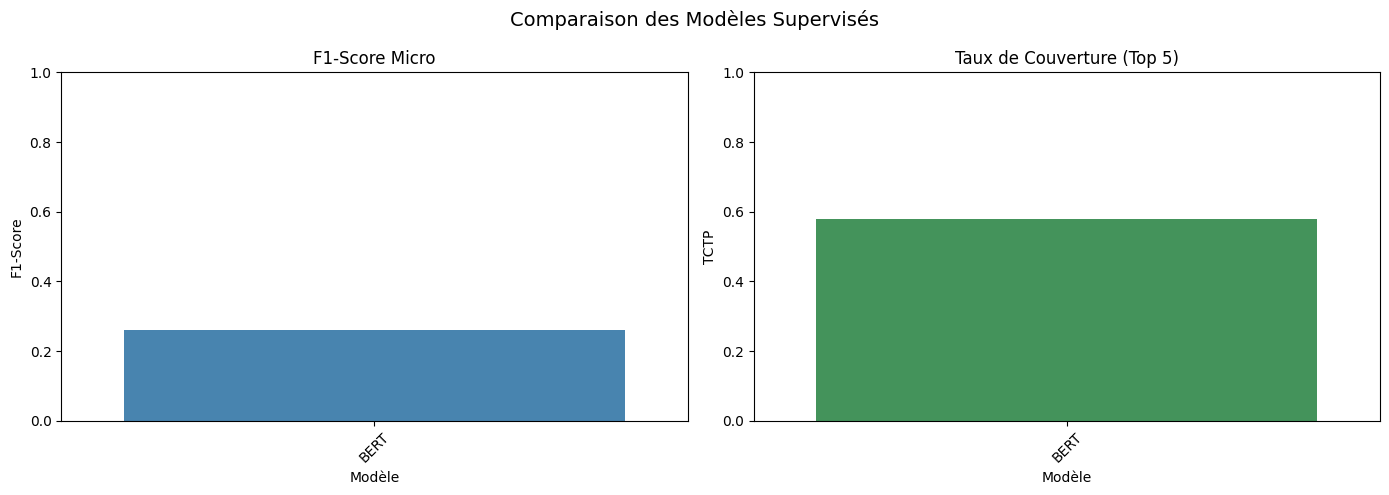

In [ ]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

K_SUGGEST = 5 
EXPERIMENT_NAME = "Approche_Supervisee_Features"
client = MlflowClient()
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)

if experiment:
    # Récupérer tous les runs (sans filtre problématique)
    runs_data = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=[f"metrics.tctp_top_{K_SUGGEST} DESC"]
    )
    
    results = []
    for run in runs_data:
        # Vérifier que le run a bien la métrique TCTP
        if f'tctp_top_{K_SUGGEST}' in run.data.metrics:
            
            feature_type = run.data.params.get('feature_type', 'N/A')
            # Nettoyage des noms
            if feature_type == 'TF-IDF (BoW)':
                feature_type = 'TF-IDF'
            elif feature_type == 'Word2Vec_Mean':
                feature_type = 'Word2Vec'
            
            results.append({
                'Modèle': feature_type,
                'F1_Micro': run.data.metrics.get('f1_micro', 0),
                'TCTP_Top5': run.data.metrics.get(f'tctp_top_{K_SUGGEST}', 0),
                'Temps_Entrainement_sec': run.data.metrics.get('fit_time_sec', 0),
            })

    if results:  # Vérifier qu'on a des résultats
        df_results = pd.DataFrame(results).sort_values(by='TCTP_Top5', ascending=False)
        
        print("\n Tableau Récapitulatif des Performances :\n")
        print(df_results.to_markdown(index=False))

        # --- Graphique ---
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))
        
        sns.barplot(x='Modèle', y='F1_Micro', data=df_results, ax=ax[0], palette="Blues_d")
        ax[0].set_title('F1-Score Micro')
        ax[0].set_ylabel('F1-Score')
        ax[0].set_ylim(0, 1)  # Échelle fixe pour mieux comparer
        ax[0].tick_params(axis='x', rotation=45)
        
        sns.barplot(x='Modèle', y='TCTP_Top5', data=df_results, ax=ax[1], palette="Greens_d")
        ax[1].set_title(f'Taux de Couverture (Top {K_SUGGEST})')
        ax[1].set_ylabel('TCTP')
        ax[1].set_ylim(0, 1)
        ax[1].tick_params(axis='x', rotation=45)

        plt.suptitle('Comparaison des Modèles Supervisés', fontsize=14)
        plt.tight_layout()
        plt.savefig('comparaison_modeles.png', dpi=150, bbox_inches='tight')  # Sauvegarde pour le rapport
        plt.show()
    else:
        print(" Aucun run avec la métrique TCTP trouvé.")
else:
    print(" Expérience non trouvée.")